In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la

# Problems 1, 3, 4, 6, 8

In [66]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        '''
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        '''
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        
    def evolve(self,x0,N):
        '''
        Compute the first N states and observations generated by 
        the Kalman system
        
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.
        
        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        '''
        # create functions to return our noise for the states and observations
        def ɛ():
            return np.random.multivariate_normal(np.zeros(4),self.Q)
        def δ():
            return np.random.multivariate_normal(np.zeros(2),self.R)
        m,n = self.H.shape
        states = np.zeros((n,N))
        obs = np.zeros((m,N))
        states[:,0] = x0
        obs[:,0] = self.H.dot(x0) + δ()
        
        # iterate over the states transition
        for k in range(1,N):
            states[:,k] = self.F.dot(states[:,k-1]) + self.u + ɛ()
            obs[:,k] = self.H.dot(states[:,k]) + δ()
        return states, obs
    
    def estimate(self,x,P,z):
        '''
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).
            
        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        '''
        n = x.shape[0]
        N = z.shape[1]
        out = np.zeros((n,N))
        
        # Naming: xkp is x at time k predicted, xku is x at time k updated
        
        # Initial Predict
        xkp = self.F.dot(x) + self.u
        Pkp = self.F.dot(P.dot(self.F.T)) + self.Q
        
        for k in range(N):
            # Update
            yk = z[:,k] - self.H.dot(xkp)
            Sk = self.H.dot(Pkp.dot(self.H.T)) + self.R
            Kk = la.solve(Sk.T, self.H.dot(Pkp.T)).T
            xku = xkp + Kk.dot(yk)
            out[:,k] = xku
            Pku = (np.eye(n) - Kk.dot(self.H)).dot(Pkp)
            
            # Predict
            xkp = self.F.dot(xku) + self.u
            Pkp = self.F.dot(Pku.dot(self.F.T)) + self.Q
        return out
    
    def predict(self,x,k):
        '''
        Predict the next k states in the absence of observations.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.
        
        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        '''
        n = x.shape[0]
        out = np.zeros((n,k))
        out[:,0] = self.F.dot(x) + self.u
        
        # iterate forward in time
        for i in range(1,k):
            out[:,i] = self.F.dot(out[:,i-1]) + self.u
        return out
    
    def rewind(self,x,k):
        '''
        Predict the k states preceding the current state estimate x.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of preceding states to predict.
        
        Returns
        -------
        out : ndarray of shape (n,k)
            The k preceding predicted states.
        '''
        # define a function that gives us our random noise
        def ɛ():
            return np.random.multivariate_normal(np.zeros(4),self.Q)
        n = x.shape[0]
        out = np.zeros((n,k))
        out[:,-1] = la.solve(self.F,x - self.u - ɛ())
        
        # iterate backwards in time
        for i in range(k-2,-1,-1):
            out[:,i] = la.solve(self.F, out[:,i+1] - self.u - ɛ())
        return out

# Problem 2

In [67]:
# Define our model
F = np.array([[1,0,.1,0],
              [0,1,0,.1],
              [0,0,1,0],
              [0,0,0,1]])
Q = np.eye(4)*.1
u = np.array([0,0,0,-.98])
H = np.array([[1,0,0,0],
              [0,1,0,0]])
R = 5000*np.eye(2)
kf = KalmanFilter(F,Q,H,R,u)

# Problem 3

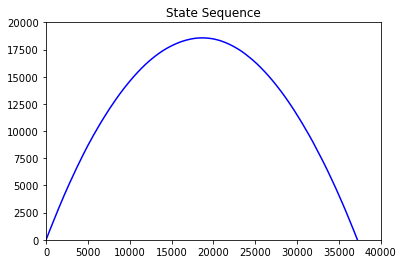

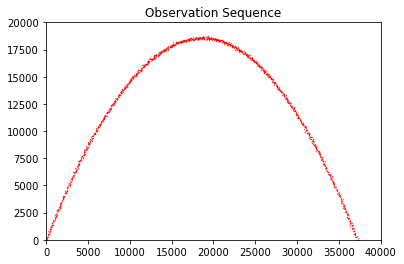

In [68]:
# Define our initial steps
x0 = np.array([0,0,300,600])
states,obs = kf.evolve(x0,1250)

# Plot that thing
plt.plot(states[0],states[1],'b')
plt.title("State Sequence")
plt.xlim((0,40000))
plt.ylim((0,20000))
plt.show()
plt.scatter(obs[0],obs[1], s=.1, c='r')
plt.title("Observation Sequence")
plt.xlim((0,40000))
plt.ylim((0,20000))
plt.show()

# Problem 5

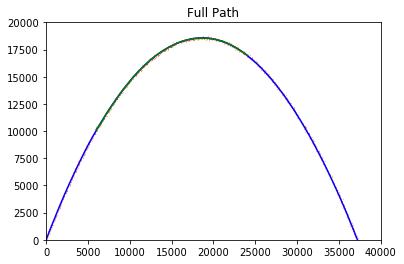

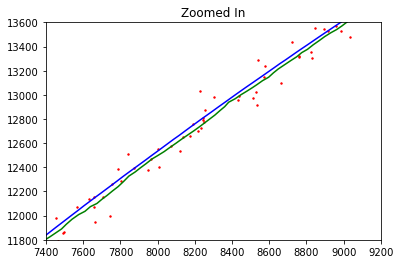

In [69]:
# Create our initial estimate
x200 = np.concatenate((obs[:,200],
                       np.diff(obs[:,200:209],axis=1).mean(axis=1)))
P200 = 1e6*Q
xhat = kf.estimate(x200,P200,obs[:,201:801])

# Plot the entire path
plt.plot(states[0],states[1],'b')
plt.scatter(obs[0],obs[1],s=.01,c='r')
plt.plot(xhat[0],xhat[1],'g')
plt.xlim((0,40000))
plt.ylim((0,20000))
plt.title("Full Path")
plt.show()

# Plot the zoomed in portion
plt.plot(states[0],states[1],'b')
plt.scatter(obs[0],obs[1],s=2,c='r')
plt.plot(xhat[0],xhat[1],'g')
plt.xlim((7400,9200))
plt.ylim((11800,13600))
plt.title("Zoomed In")
plt.show()

# Problem 7

In [ ]:
# Predict
x800 = xhat[:,-1]
prediction = kf.predict(x800,450)

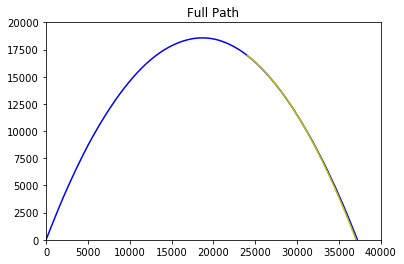

In [122]:
# Plot
plt.plot(states[0],states[1],'b')
plt.plot(prediction[0],prediction[1],'y')
plt.xlim((0,40000))
plt.ylim((0,20000))
plt.title("Full Path")
plt.show()

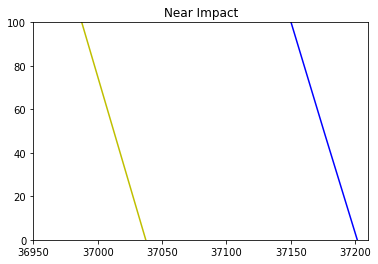

In [128]:
# Plot near impact
plt.plot(states[0],states[1],'b')
plt.plot(prediction[0],prediction[1],'y')
plt.xlim((36950,37210))
plt.ylim((0,100))
plt.title("Near Impact")
plt.show()

# Problem 9

In [112]:
# Get estimates starting from both k=250 and k=600
x250 = xhat[:,49]
postdiction1 = kf.rewind(x250,1000)

x600 = xhat[:,599]
postdiction2 = kf.rewind(x600,3000)

In [115]:
# drop ones that go far beyond point of origin
xpostdiction1 = postdiction1[0][postdiction1[1]>-100]
ypostdiction1 = postdiction1[1][postdiction1[1]>-100]
xpostdiction2 = postdiction2[0][postdiction2[1]>-100]
ypostdiction2 = postdiction2[1][postdiction2[1]>-100]

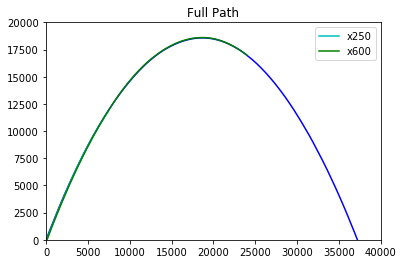

In [116]:
# plot the full path
plt.plot(states[0], states[1], 'b')
plt.plot(xpostdiction1, ypostdiction1, 'c', label='x250')
plt.plot(xpostdiction2, ypostdiction2, 'g', label='x600')
plt.legend()
plt.xlim((0,40000))
plt.ylim((0,20000))
plt.title("Full Path")
plt.show()

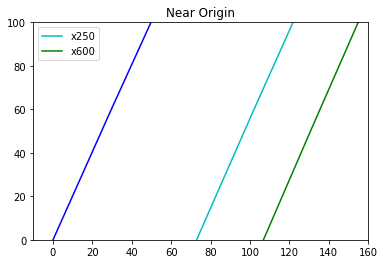

In [129]:
# plot near origin
plt.plot(states[0], states[1], 'b')
plt.plot(xpostdiction1, ypostdiction1, 'c', label='x250')
plt.plot(xpostdiction2, ypostdiction2, 'g', label='x600')
plt.legend()
plt.xlim((-10,160))
plt.ylim((0,100))
plt.title("Near Origin")
plt.show()

Above, we see that starting from $x_{250}$ is a better starting option, which makes sense because we will be thrown off by the random noise less since are closer to the point we are trying to estimate.